In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy
from matplotlib.pyplot import imshow
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
np.random.seed(25)
tf.executing_eagerly()

# A function to compute the value of latent space
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2],new_images.shape[3])
   # x=array_to_img(new_images[no_of_imgs/2])
    #x.save('#.jpg')
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    plt.imsave('test.png',new_images[int(no_of_imgs/2)],cmap='autumn_r')
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='autumn_r')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

# Loading dataset
SIZE=512
from tqdm import tqdm
img_data=[]
path1 = 'Scene/v1'
files=os.listdir(path1)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    img_data.append(img_to_array(img))

img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_array = img_array.astype('float32') /(SIZE-1)
X_train = img_array

fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0

# Normalize values such that all numbers are within
# the range of 0 to 1

# Convert from (no_of_data, 256, 256) to (no_of_data, 256, 256, 3)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)


# Defining some variables
img_height   = X_train_new.shape[1]    # 256
img_width    = X_train_new.shape[2]    # 256
num_channels = X_train_new.shape[3]    # 3
input_shape =  (img_height, img_width, num_channels)   # (256,256,3)
latent_dim = 2    # Dimension of the latent space


# Constructing encoder
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=32, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=64, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=128, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(encoder_conv)

# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=128, kernel_size=3, strides=2, 
                            padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

# Actually build encoder, decoder and the entire VAE
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))

# Compile the model using KL loss
opt=Adam(learning_rate=0.00001)
vae.compile(optimizer=opt,loss=kl_reconstruction_loss)

# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=100, batch_size=148)

# Plotting loss value decrease
plt.plot(history.history['loss'])


# Transform images to points in latent space using encoder
encoded = encoder.predict(X_train_new)

# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()

display_image_sequence(encoded[10,0],encoded[10,1],encoded[12,0],encoded[12,1],10)

 13%|█▎        | 131/1044 [00:10<01:14, 12.25it/s]


KeyboardInterrupt: 

In [1]:
display_image_sequence(encoded[12,0],encoded[12,1],encoded[10,0],encoded[10,1],5)

NameError: name 'display_image_sequence' is not defined

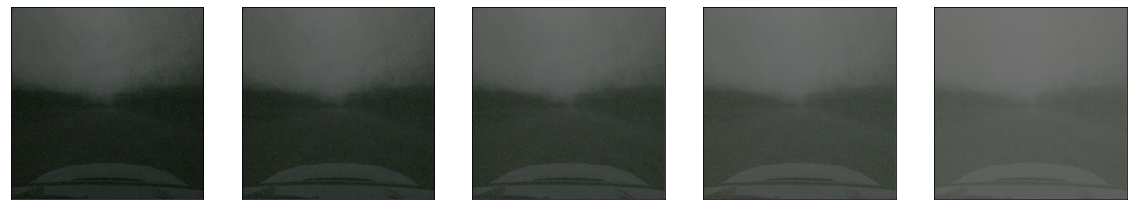

In [4]:
display_image_sequence(encoded[10,0],encoded[10,1],encoded[12,0],encoded[12,1],5)#512-10

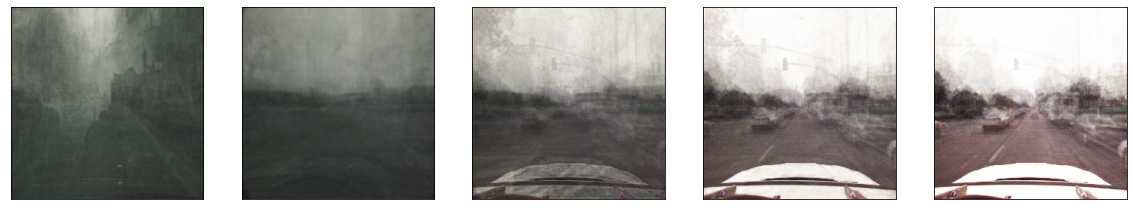

In [2]:
display_image_sequence(encoded[10,0],encoded[10,1],encoded[12,0],encoded[12,1],5)#256-200

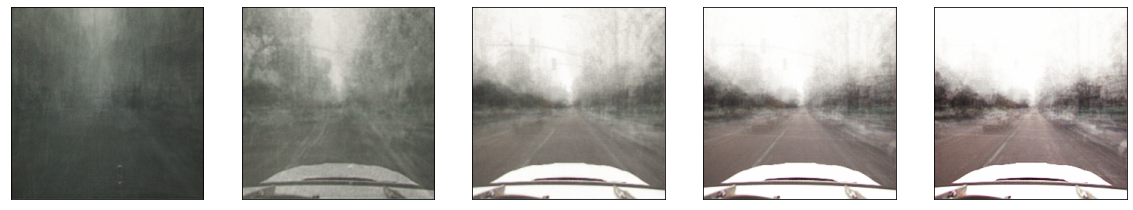

In [3]:
display_image_sequence(encoded[10,0],encoded[10,1],encoded[12,0],encoded[12,1],5)

In [4]:
from keras.preprocessing.image import array_to_img
x=array_to_img(X_train[10])
x.save('PIC1.jpg')
x=array_to_img(X_train[12])
x.save('PIC2.jpg')

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
#from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from matplotlib.pyplot import imshow
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
np.random.seed(25)
tf.executing_eagerly()

# A function to compute the value of latent space
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2],new_images.shape[3])
   # x=array_to_img(new_images[no_of_imgs/2])
    #x.save('#.jpg')
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    plt.imsave('test.png',new_images[int(no_of_imgs/2)],cmap='autumn_r')
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='autumn_r')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

# Loading dataset
SIZE=512
from tqdm import tqdm
img_data=[]
path1 = 'Scene/v1'
files=os.listdir(path1)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    img_data.append(img_to_array(img))

img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_array = img_array.astype('float32') /(SIZE-1)
X_train = img_array

fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0

# Normalize values such that all numbers are within
# the range of 0 to 1

# Convert from (no_of_data, 256, 256) to (no_of_data, 256, 256, 3)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)


# Defining some variables
img_height   = X_train_new.shape[1]    # 256
img_width    = X_train_new.shape[2]    # 256
num_channels = X_train_new.shape[3]    # 3
input_shape =  (img_height, img_width, num_channels)   # (256,256,3)
latent_dim = 2    # Dimension of the latent space


# Constructing encoder
encoder_input = Input(shape=input_shape)
encoder_conv = Conv2D(filters=4, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=32, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=64, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(encoder_conv)

# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                            padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=4, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

# Actually build encoder, decoder and the entire VAE
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))

# Compile the model using KL loss
opt=Adam(learning_rate=0.6)
vae.compile(optimizer=opt,loss=kl_reconstruction_loss)

# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=50, batch_size=32)

# Plotting loss value decrease
plt.plot(history.history['loss'])


# Transform images to points in latent space using encoder
encoded = encoder.predict(X_train_new)

# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()

display_image_sequence(encoded[10,0],encoded[10,1],encoded[12,0],encoded[12,1],10)

100%|██████████| 702/702 [00:41<00:00, 17.04it/s]


In [ ]:
display_image_sequence(encoded[10,0],encoded[10,1],encoded[20,0],encoded[20,1],5)#50 epochs-512-0.0006

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy
from matplotlib.pyplot import imshow
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
np.random.seed(25)
tf.executing_eagerly()

# A function to compute the value of latent space
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2],new_images.shape[3])
   # x=array_to_img(new_images[no_of_imgs/2])
    #x.save('#.jpg')
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    plt.imsave('test.jpg',new_images[int(no_of_imgs/2)],cmap='autumn_r')
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='autumn_r')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

# Loading dataset
SIZE=512
from tqdm import tqdm
img_data=[]
path1 = 'Scene/F'
files=os.listdir(path1)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    img_data.append(img_to_array(img))

img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_array = img_array.astype('float32') /(SIZE-1)
X_train = img_array

fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0

# Normalize values such that all numbers are within
# the range of 0 to 1

# Convert from (no_of_data, 256, 256) to (no_of_data, 256, 256, 3)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)


# Defining some variables
img_height   = X_train_new.shape[1]    # 256
img_width    = X_train_new.shape[2]    # 256
num_channels = X_train_new.shape[3]    # 3
input_shape =  (img_height, img_width, num_channels)   # (256,256,3)
latent_dim = 2    # Dimension of the latent space


# Constructing encoder
encoder_input = Input(shape=input_shape)
encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=32, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=64, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(encoder_conv)

# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                            padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

# Actually build encoder, decoder and the entire VAE
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))

# Compile the model using KL loss
opt=Adam(learning_rate=0.01)
vae.compile(optimizer=opt,loss=kl_reconstruction_loss)

# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=100, batch_size=21)

# Plotting loss value decrease
plt.plot(history.history['loss'])


# Transform images to points in latent space using encoder
encoded = encoder.predict(X_train_new)

# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()

display_image_sequence(encoded[10,0],encoded[10,1],encoded[12,0],encoded[12,1],10)

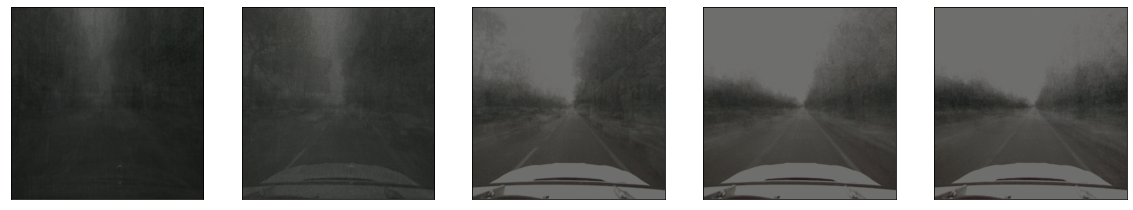

In [4]:
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2],new_images.shape[3])
   # x=array_to_img(new_images[no_of_imgs/2])
    #x.save('#.jpg')
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    plt.imsave('test.jpg',new_images[int(no_of_imgs/2)],cmap='autumn_r')
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='autumn_r')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

display_image_sequence(encoded[10,0],encoded[10,1],encoded[20,0],encoded[20,1],5)

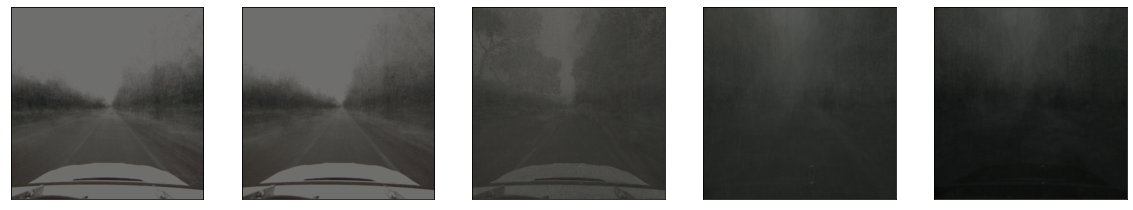

In [5]:
display_image_sequence(encoded[0,0],encoded[0,1],encoded[2,0],encoded[2,1],5)

100%|██████████| 84/84 [00:01<00:00, 67.61it/s]


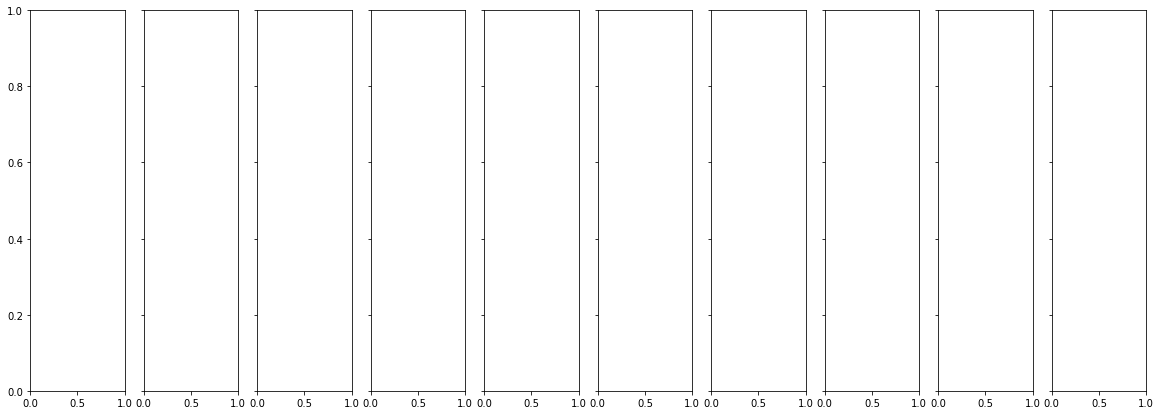

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy
from matplotlib.pyplot import imshow
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
np.random.seed(25)
tf.executing_eagerly()
SIZE=512
from tqdm import tqdm
img_data=[]
path1 = 'Scene/F'
files=os.listdir(path1)
for i in tqdm(files):
    img=cv2.imread(path1+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    img_data.append(img_to_array(img))

img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
img_array = img_array.astype('float32') /(SIZE-1)
X_train = img_array

fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0


Train on 84 samples
Epoch 1/400
84/84 [==============================] - 9s 107ms/sample - loss: 186060.8242
Epoch 2/400
84/84 [==============================] - 8s 100ms/sample - loss: 181626.6406
Epoch 3/400
84/84 [==============================] - 10s 121ms/sample - loss: 181538.9961
Epoch 4/400
84/84 [==============================] - 10s 123ms/sample - loss: 181404.5273
Epoch 5/400
84/84 [==============================] - 10s 124ms/sample - loss: 181217.1680
Epoch 6/400
84/84 [==============================] - 10s 121ms/sample - loss: 180955.6562
Epoch 7/400
84/84 [==============================] - 10s 122ms/sample - loss: 180601.2109
Epoch 8/400
84/84 [==============================] - 10s 121ms/sample - loss: 180103.6719
Epoch 9/400
84/84 [==============================] - 10s 120ms/sample - loss: 179452.4805
Epoch 10/400
84/84 [==============================] - 11s 127ms/sample - loss: 178620.4570
Epoch 11/400
84/84 [==============================] - 10s 122ms/sample - loss: 17

Epoch 91/400
84/84 [==============================] - 11s 128ms/sample - loss: 133158.8828
Epoch 92/400
84/84 [==============================] - 10s 123ms/sample - loss: 133106.6348
Epoch 93/400
84/84 [==============================] - 10s 124ms/sample - loss: 133062.3965
Epoch 94/400
84/84 [==============================] - 10s 122ms/sample - loss: 133010.8867
Epoch 95/400
84/84 [==============================] - 10s 125ms/sample - loss: 132961.2754
Epoch 96/400
84/84 [==============================] - 10s 123ms/sample - loss: 132910.6797
Epoch 97/400
84/84 [==============================] - 10s 122ms/sample - loss: 132874.1426
Epoch 98/400
84/84 [==============================] - 10s 124ms/sample - loss: 132837.8574
Epoch 99/400
84/84 [==============================] - 10s 122ms/sample - loss: 132794.9844
Epoch 100/400
84/84 [==============================] - 11s 126ms/sample - loss: 132752.0215
Epoch 101/400
84/84 [==============================] - 10s 123ms/sample - loss: 132701.75

84/84 [==============================] - 10s 123ms/sample - loss: 131530.5332
Epoch 181/400
84/84 [==============================] - 11s 127ms/sample - loss: 131460.7715
Epoch 182/400
84/84 [==============================] - 10s 125ms/sample - loss: 131449.1035
Epoch 183/400
84/84 [==============================] - 10s 122ms/sample - loss: 131441.4453
Epoch 184/400
84/84 [==============================] - 10s 122ms/sample - loss: 131430.8965
Epoch 185/400
84/84 [==============================] - 10s 123ms/sample - loss: 131457.5020
Epoch 186/400
84/84 [==============================] - 11s 126ms/sample - loss: 131439.4141
Epoch 187/400
84/84 [==============================] - 10s 124ms/sample - loss: 131465.8887
Epoch 188/400
84/84 [==============================] - 10s 123ms/sample - loss: 131514.3301
Epoch 189/400
84/84 [==============================] - 10s 125ms/sample - loss: 131443.3613
Epoch 190/400
84/84 [==============================] - 10s 123ms/sample - loss: 131397.7305
Ep

84/84 [==============================] - 11s 128ms/sample - loss: 131009.8320
Epoch 270/400
84/84 [==============================] - 11s 130ms/sample - loss: 131001.3105
Epoch 271/400
84/84 [==============================] - 10s 122ms/sample - loss: 131024.5996
Epoch 272/400
84/84 [==============================] - 10s 123ms/sample - loss: 131017.4258
Epoch 273/400
84/84 [==============================] - 10s 124ms/sample - loss: 131005.4531
Epoch 274/400
84/84 [==============================] - 10s 125ms/sample - loss: 131000.0723
Epoch 275/400
84/84 [==============================] - 10s 123ms/sample - loss: 131014.6289
Epoch 276/400
84/84 [==============================] - 10s 124ms/sample - loss: 131048.0762
Epoch 277/400
84/84 [==============================] - 10s 123ms/sample - loss: 131046.9688
Epoch 278/400
84/84 [==============================] - 11s 126ms/sample - loss: 131046.7031
Epoch 279/400
84/84 [==============================] - 10s 124ms/sample - loss: 131001.2109
Ep

84/84 [==============================] - 10s 123ms/sample - loss: 130763.5000
Epoch 359/400
84/84 [==============================] - 10s 123ms/sample - loss: 130767.5488
Epoch 360/400
84/84 [==============================] - 11s 128ms/sample - loss: 130759.0898
Epoch 361/400
84/84 [==============================] - 10s 124ms/sample - loss: 130775.6250
Epoch 362/400
84/84 [==============================] - 10s 124ms/sample - loss: 130752.9531
Epoch 363/400
84/84 [==============================] - 10s 123ms/sample - loss: 130752.6016
Epoch 364/400
84/84 [==============================] - 11s 131ms/sample - loss: 130748.0527
Epoch 365/400
84/84 [==============================] - 10s 124ms/sample - loss: 130740.7812
Epoch 366/400
84/84 [==============================] - 10s 124ms/sample - loss: 130751.6406
Epoch 367/400
84/84 [==============================] - 10s 123ms/sample - loss: 130783.8301
Epoch 368/400
84/84 [==============================] - 10s 124ms/sample - loss: 130754.6328
Ep

/home/killer/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


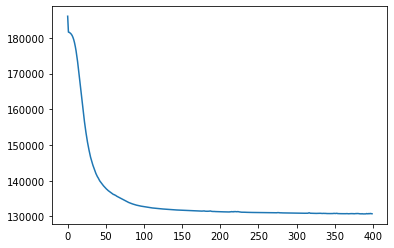

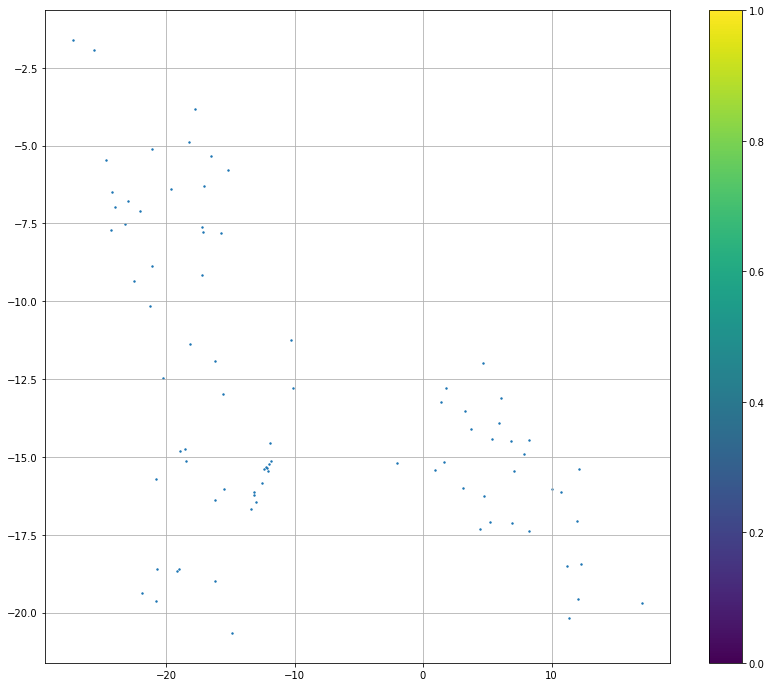

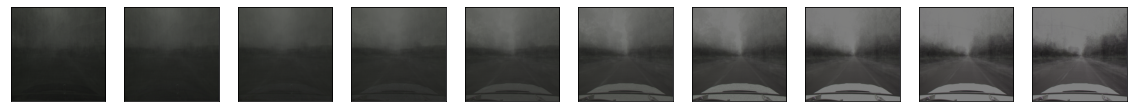

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy
from matplotlib.pyplot import imshow
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
np.random.seed(25)
tf.executing_eagerly()

# A function to compute the value of latent space
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2],new_images.shape[3])
   # x=array_to_img(new_images[no_of_imgs/2])
    #x.save('#.jpg')
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    plt.imsave('test.png',new_images[int(no_of_imgs/2)],cmap='autumn_r')
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='autumn_r')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

# Loading dataset
# SIZE=512
# from tqdm import tqdm
# img_data=[]
# path1 = 'Scene/v1'
# files=os.listdir(path1)
# for i in tqdm(files):
#     img=cv2.imread(path1+'/'+i,1)   #Change 0 to 1 for color images
#     img=cv2.resize(img,(SIZE, SIZE))
#     img_data.append(img_to_array(img))

# img_array = np.reshape(img_data, (len(img_data), SIZE, SIZE, 3))
# img_array = img_array.astype('float32') /(SIZE-1)
# X_train = img_array

# fig, axes = plt.subplots(ncols=10, sharex=False,
#     sharey=True, figsize=(20, 7))
# counter = 0

# Normalize values such that all numbers are within
# the range of 0 to 1

# Convert from (no_of_data, 256, 256) to (no_of_data, 256, 256, 3)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)


# Defining some variables
img_height   = X_train_new.shape[1]    # 256
img_width    = X_train_new.shape[2]    # 256
num_channels = X_train_new.shape[3]    # 3
input_shape =  (img_height, img_width, num_channels)   # (256,256,3)
latent_dim = 2    # Dimension of the latent space


# Constructing encoder
encoder_input = Input(shape=input_shape)
encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=32, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=64, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(encoder_conv)

# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                            padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

# Actually build encoder, decoder and the entire VAE
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))

# Compile the model using KL loss
opt=Adam(learning_rate=0.00006)
vae.compile(optimizer=opt,loss=kl_reconstruction_loss)

# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=400, batch_size=21)

# Plotting loss value decrease
plt.plot(history.history['loss'])


# Transform images to points in latent space using encoder
encoded = encoder.predict(X_train_new)

# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()
display_image_sequence(encoded[10,0],encoded[10,1],encoded[12,0],encoded[12,1],10)

In [6]:
#10-12


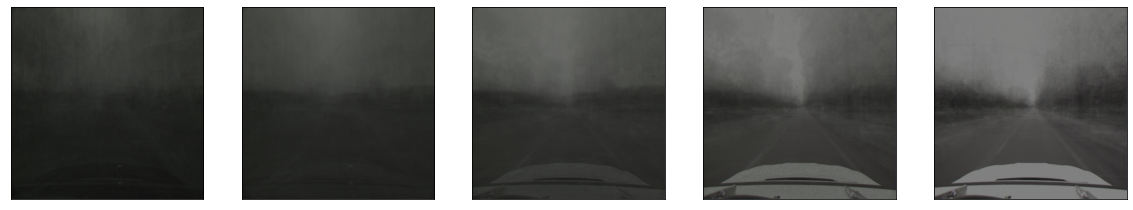

In [4]:
from keras.preprocessing.image import array_to_img
x1=57
x2=72
x=array_to_img(X_train[x1])
x.save('PIC1.jpg')
x=array_to_img(X_train[x2])
x.save('PIC2.jpg')
display_image_sequence(encoded[x1,0],encoded[x1,1],encoded[x2,0],encoded[x2,1],5)